<a href="https://colab.research.google.com/github/rheopy/rheofit/blob/master/data/Rheology%20finds%20distinct%20glass%20and%20jamming%20transitions%20in%20emulsions/TC_analysis_fig2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rheopy/rheofit.git

  Cloning https://github.com/rheopy/rheofit.git to /tmp/pip-req-build-d0owxzkl
  Running command git clone -q https://github.com/rheopy/rheofit.git /tmp/pip-req-build-d0owxzkl
  Created wheel for rheofit: filename=rheofit-0.1.0-cp36-none-any.whl size=9874 sha256=e83e8d0dea2a4b27b8dd9c7257ecbf1f73b03f03b15fe63dd7c6b5e2317cf264
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1js58pd/wheels/a4/58/61/22fb357c158d287fa7e6b6a2b1cc7379d68d1d40fdbb8daf64
Successfully built rheofit


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from IPython.display import Math

import rheofit
import pybroom as pb
import corner

import seaborn as sns
import io
from scipy.interpolate import UnivariateSpline
import numpy as np


In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [4]:
!git clone https://github.com/rheopy/rheofit.git

fatal: destination path 'rheofit' already exists and is not an empty directory.


In [5]:
#check units - assuming SI

filename_fig2a='2011.11806_fig2a_Shear rate_Stress_s-1_Pa.csv'
xlabel=filename_fig2a.split('_')[2]
ylabel=filename_fig2a.split('_')[3]

sample_list=list(pd.read_csv(f'/content/rheofit/data/Rheology finds distinct glass and jamming transitions in emulsions/{filename_fig2a}',nrows=1).columns)[::2]
data_table=pd.read_csv('/content/rheofit/data/Rheology finds distinct glass and jamming transitions in emulsions/2011.11806_fig2a_Shear rate_Stress_s-1_Pa.csv',skiprows=1)
data_table

data_dict={}
for sample_index, sample_label in enumerate(sample_list):
  single_table=data_table.iloc[:,[sample_index*2,sample_index*2+1]]
  single_table.columns=[xlabel,ylabel]
  single_table.sort_values(by=xlabel,inplace=True)

  data_dict[sample_label]=single_table

# data interpolation example
# data=pd.read_excel('FC_0775.xlsx')
# int_y=UnivariateSpline(data['Shear rate'],data['Stress'],k=1)
# int_x=np.logspace(np.log10(min(data['Shear rate'])),np.log10(max(data['Shear rate'])),100)
# int_data=pd.DataFrame()
# int_data['Shear rate']=int_x
# int_data['Stress']=int_y(int_x)
# data_dict['FC_0775.xlsx']=data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [21]:
TC=rheofit.models.TC_model
TC.set_param_hint('TC_gammadot_crit', vary=False, value=10)

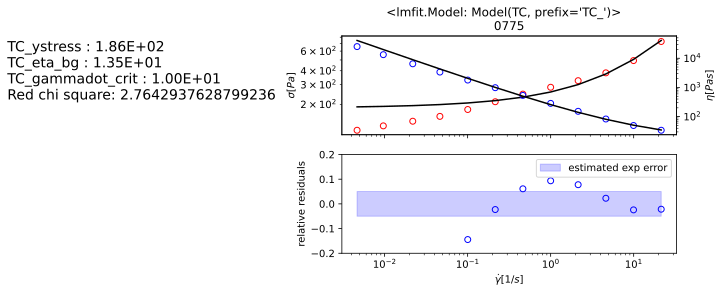

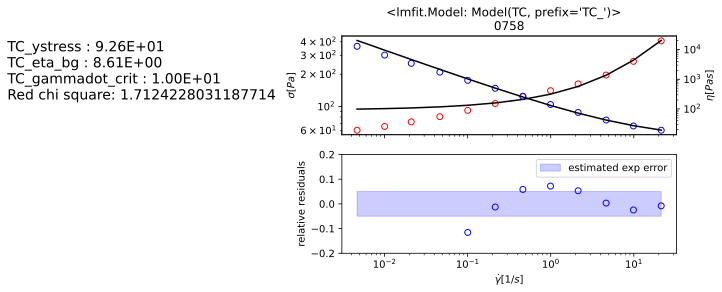

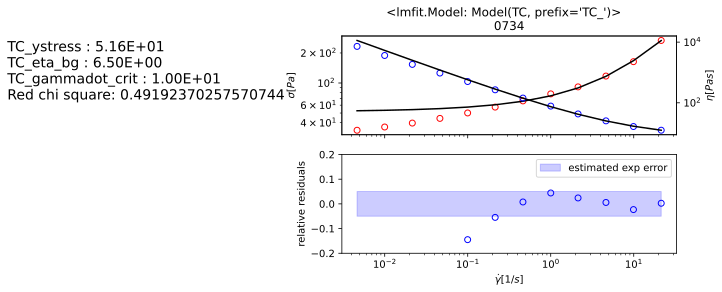

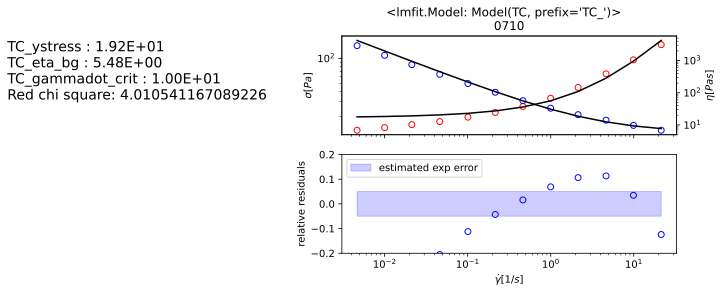

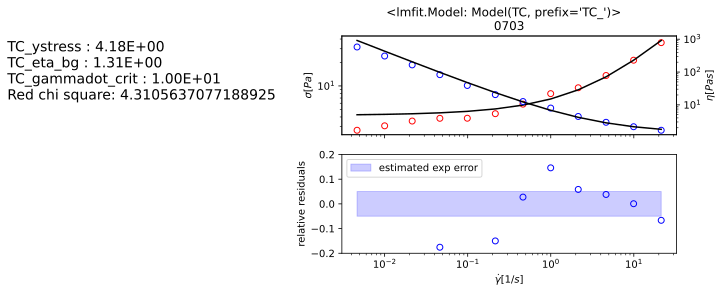

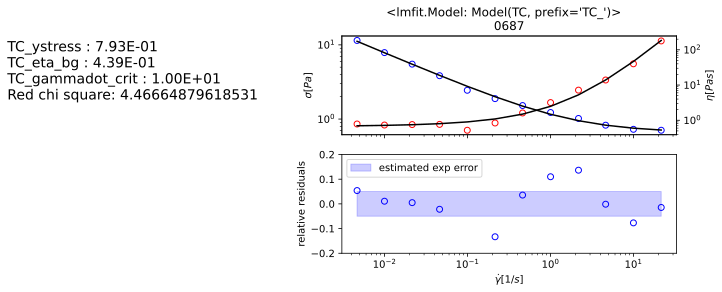

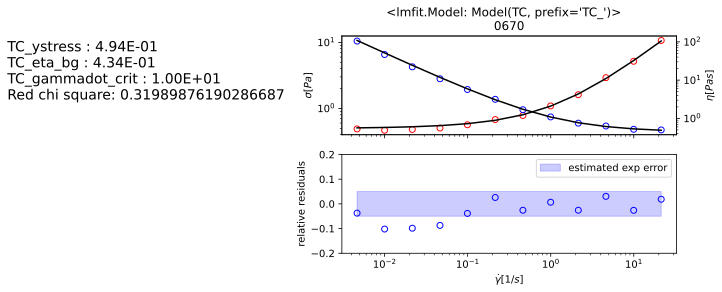

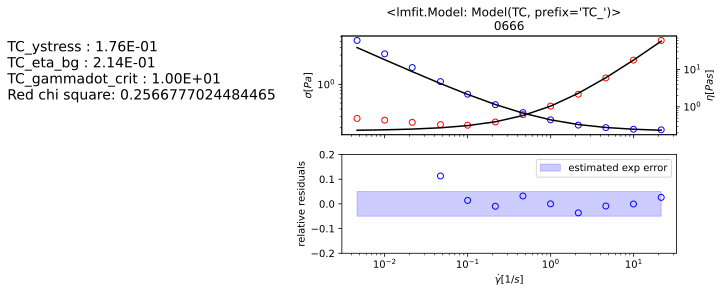

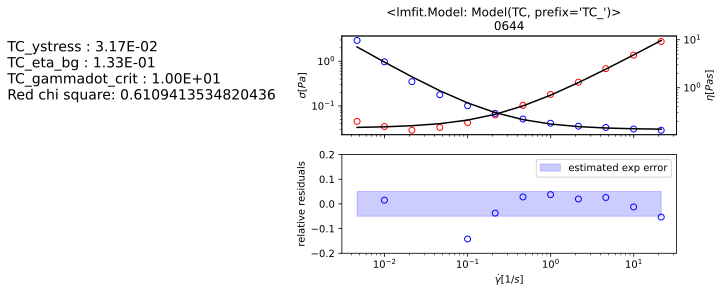

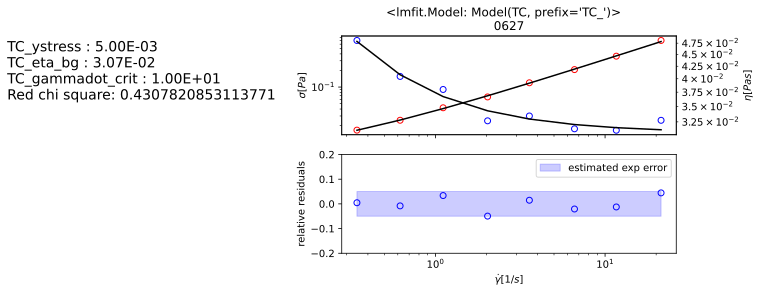

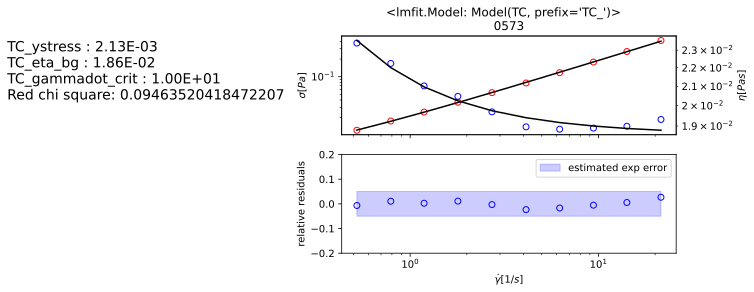

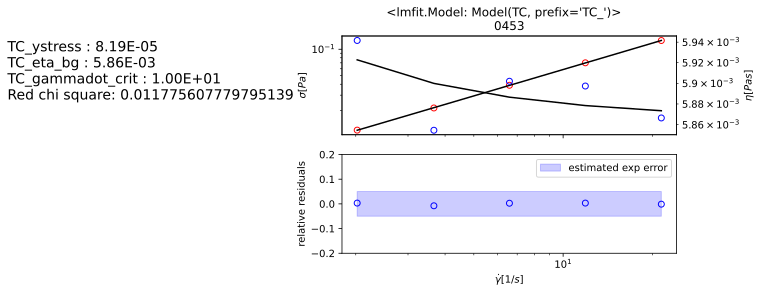

In [22]:
fit_res_dict={}

model = TC

min_shear_rate=0.1

max_shear_rate=10000

for filename, data in data_dict.items():
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)    
    fit_res=model.fit(data['Stress'],x=data['Shear rate'],
                                     weights=1/(0.05*data[mask]['Stress']),
                                     nan_policy='omit')
    fit_res_dict[filename]=fit_res
    rheofit.visualization.update_par_widget(par_wid,fit_res)
    
for filename,fit_res in fit_res_dict.items():
    rheofit.visualization.plot_fit_res(fit_res, show_par_values=True);
    plt.title(filename)

In [23]:
table_result=pb.tidy(fit_res_dict)
table_result['vol_frac']=table_result['key'].map(lambda x: int(x[1:])/1000)
table_result.pivot(index='vol_frac', columns='name', values='value')

name      TC_eta_bg  TC_gammadot_crit  TC_ystress
vol_frac                                         
0.453      0.005864              10.0    0.000082
0.573      0.018552              10.0    0.002129
0.627      0.030713              10.0    0.004995
0.644      0.133067              10.0    0.031679
0.666      0.214489              10.0    0.175860
0.67       0.433513              10.0    0.494500
0.687      0.439186              10.0    0.793115
0.703      1.312467              10.0    4.175765
0.71       5.477294              10.0   19.230749
0.734      6.499465              10.0   51.581235
0.758      8.606007              10.0   92.645245
0.775     13.529117              10.0  185.576693

Text(0.5, 0, 'Shear rate')

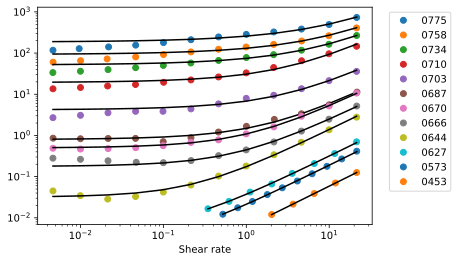

In [37]:
for label,fit_res in fit_res_dict.items():
  plt.plot(fit_res.userkws['x'],fit_res.data,'o', label=label)
  plt.plot(fit_res.userkws['x'],fit_res.eval(), color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best', bbox_to_anchor=(1.25, 1))
plt.xlabel(xlabel)
plt.

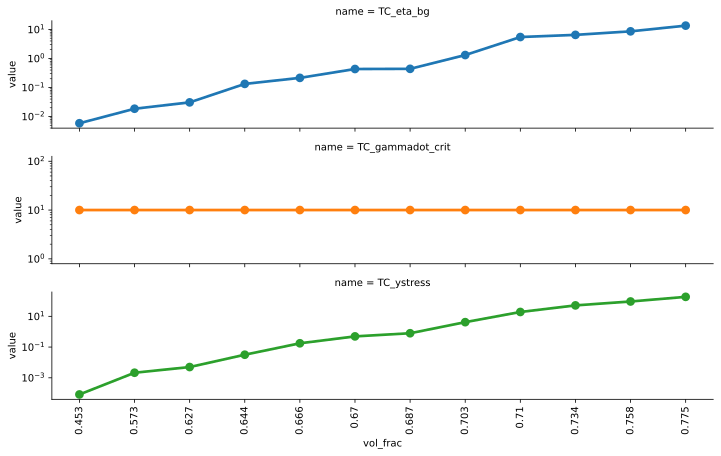

In [18]:
g = sns.catplot(x="vol_frac", y="value",
                hue="name", row="name",
                data=table_result, kind="point",
                dodge=False,
                sharey=False,
                height=2, aspect=5).set_xticklabels(rotation=90).set(yscale="log")